# Eigenbears

No eigenbears were harmed for this problem set.

In [224]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

In [225]:
# toggle settings
add_noise = False

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


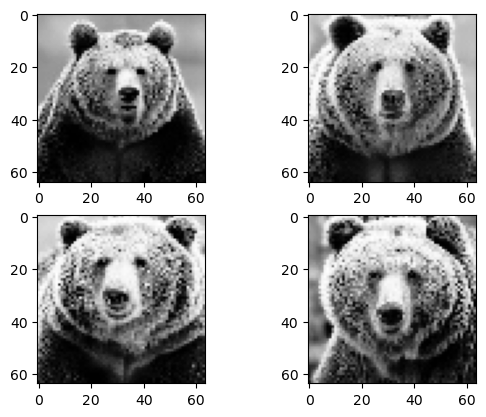

In [226]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

In [227]:
# Construct data matrix of centered data
train_images_flattened = np.array([image.flatten() for image in train_images])
mean_image = np.mean(train_images_flattened, axis = 0)
A = (train_images_flattened - mean_image).T

# Perform SVD
U, S, Vh = np.linalg.svd(A) # replace A with your centered data matrix

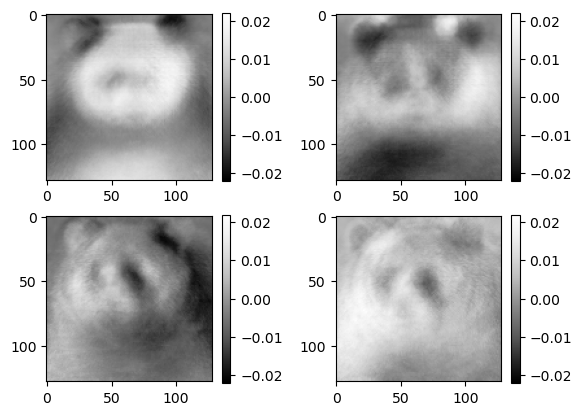

In [228]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap = 'Greys_r',
        # force colormap to be the same for all four
        vmin = -np.max(np.abs(U[:,:4])),
        vmax = np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)

These 4 first "Eigenbears" are capturing the most important features when it comes to separating pandas from brown bears.

(50, 50)
(50, 50)


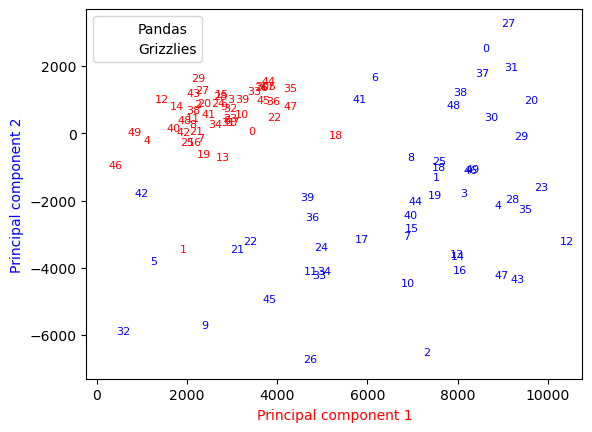

In [229]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

first_eigenbear_index = 0
second_eigenbear_index = 1

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:, first_eigenbear_index], np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:, second_eigenbear_index], np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='', lw=0, label=['Pandas', 'Grizzlies'][i])

    print((len(p1), len(p2)))

    for j in range(50):
        plt.text(p1[j], p2[j], str(j), color=("red" if i else "blue"), fontsize=8)
# annotate axes
plt.xlabel('Principal component 1', color = 'red')
plt.ylabel('Principal component 2', color = 'blue')
# add legend
plt.legend();

It's interesting to notice how when setting ```first_eigenbear_index = 14999``` and ```second_eigenbear_index = 15000``` (a pair of relatively irrelevant eigenbears) we see almost no clustering of Grizzlies but when choosing a pair of some of the most important eigenbears (like the first and second) we get some very, very strong clustering happening.

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

In [230]:
from sklearn.neighbors import KNeighborsClassifier

In [231]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [232]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')

hard_bears = {}

for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(A.T, y_train)
    # use model to make predictions on the test set
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)
    # print results to table
    missclassified_bears = (np.argwhere(errors).T)[0]
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), missclassified_bears))

    for i in missclassified_bears:
        if i in hard_bears:
            hard_bears[i] += 1
        else:
            hard_bears[i] = 1

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      9 	| [ 5  6  8 21 22 24 39 41 42]
    2	|      6 	| [ 6  8 21 22 39 42]
    3	|      10 	| [ 5  6  8 21 22 24 32 39 41 42]
    4	|      8 	| [ 5  8 21 22 32 39 41 42]
    5	|      9 	| [ 5  6  8 21 22 32 39 41 42]
    6	|      5 	| [21 22 32 39 42]
    7	|      8 	| [ 5  6 21 22 32 39 41 42]
    8	|      6 	| [ 5 21 22 39 41 42]
    9	|      8 	| [ 5  6 21 22 32 39 41 42]
    10	|      7 	| [ 5 21 22 32 39 41 42]
    11	|      8 	| [ 5  6 21 22 32 39 41 42]
    12	|      6 	| [ 5 21 22 32 41 42]
    13	|      7 	| [ 5 21 22 32 39 41 42]
    14	|      7 	| [ 5 21 22 32 39 41 42]
    15	|      7 	| [ 5 21 22 32 39 41 42]


We got the least number of errors when we used ```k = 5```.

The hardest bears to classify (from hardest to easiest) are:
[42, 22, 21, 39, 41, 5, 32, 6, 8, 24]


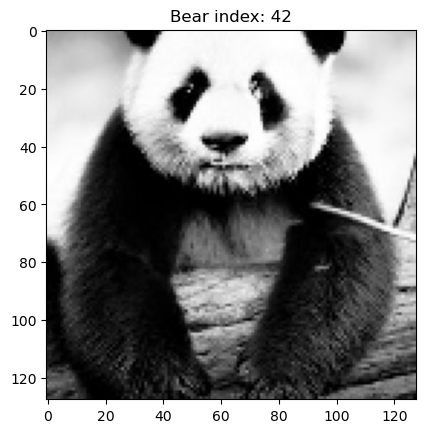

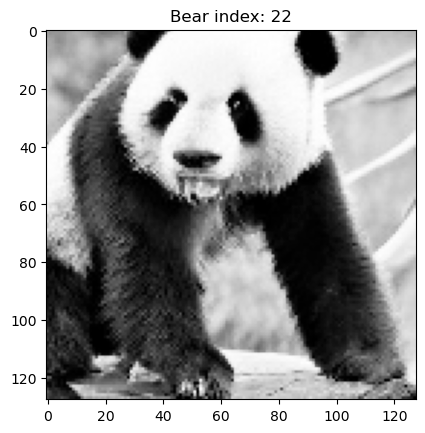

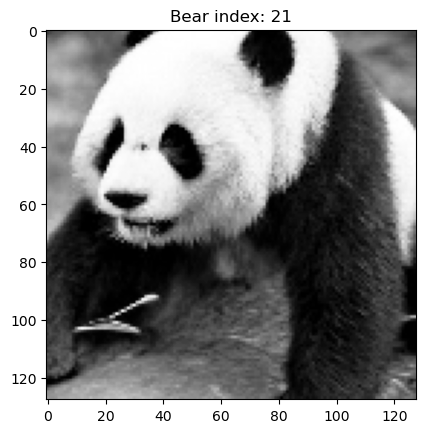

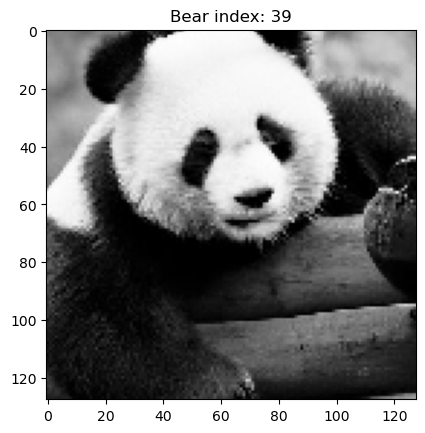

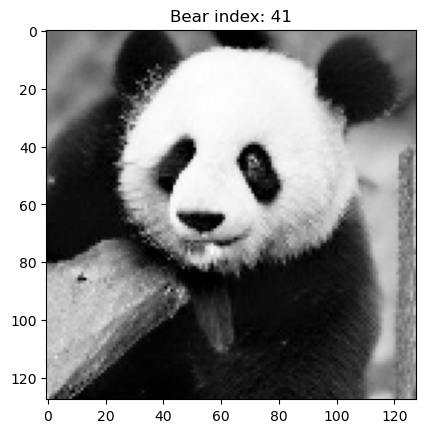

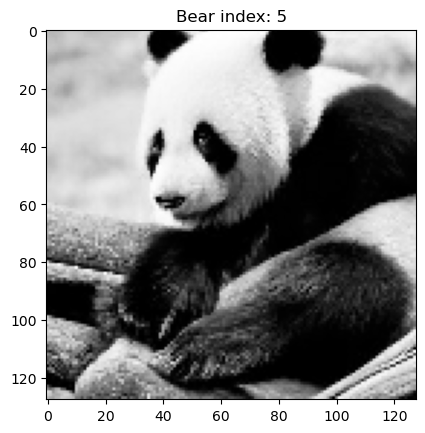

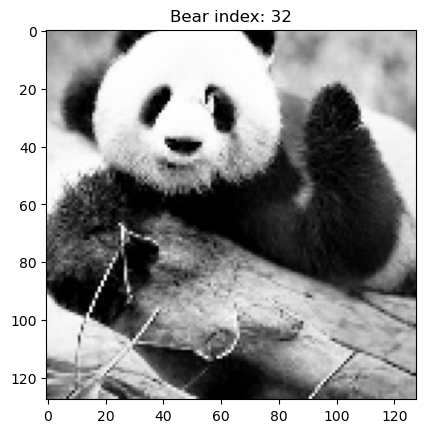

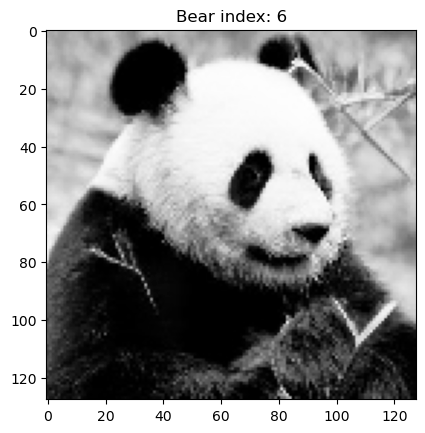

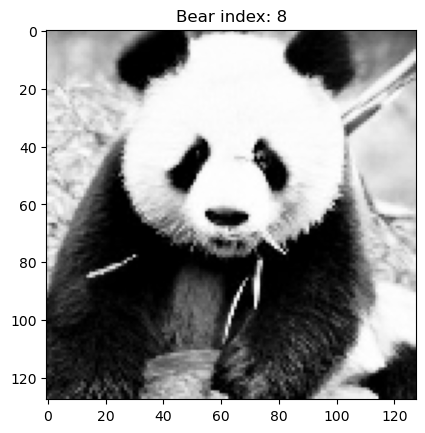

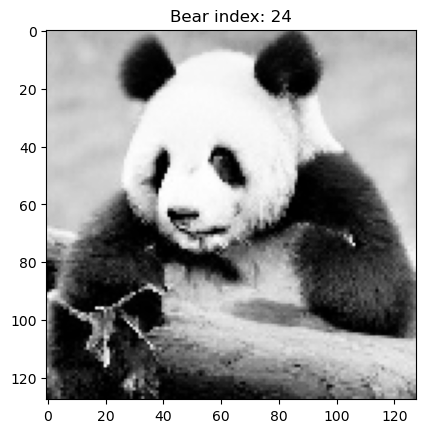

In [233]:
# Show hard-to-classify bears
sorted_bears = sorted(hard_bears.items(), key = lambda x:x[1])
sorted_bears.reverse()
sorted_bears

print('The hardest bears to classify (from hardest to easiest) are:')
print([b[0] for b in sorted_bears])

for bear_index, _ in sorted_bears:
    plt.subplot(1,1,1)
    plt.imshow(test_images[bear_index], cmap='Greys_r')
    plt.title('Bear index: {}'.format(bear_index))
    plt.show()

Apparently, only pandas are getting missclassified. Let's show some of the non-missclassified pandas to see what's the difference.

Bear index: 0


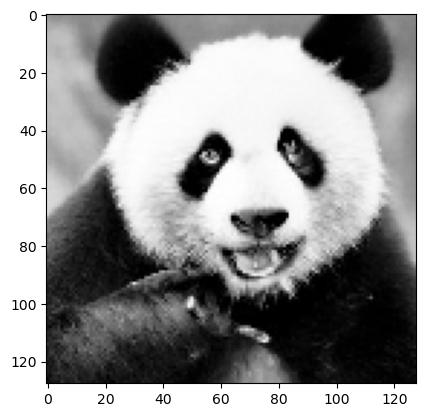

Bear index: 1


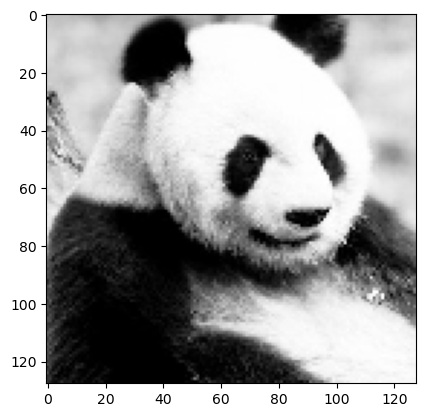

Bear index: 2


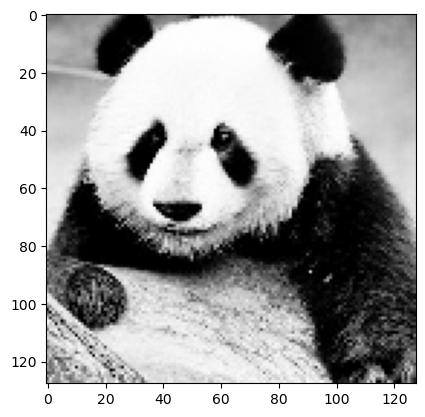

Bear index: 3


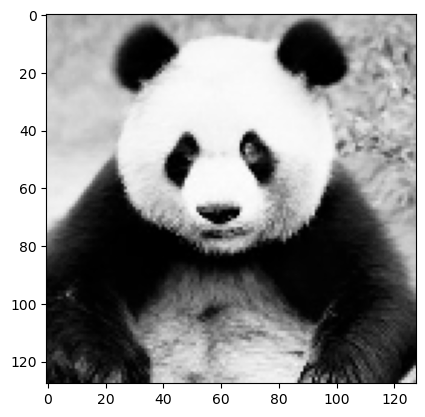

Bear index: 4


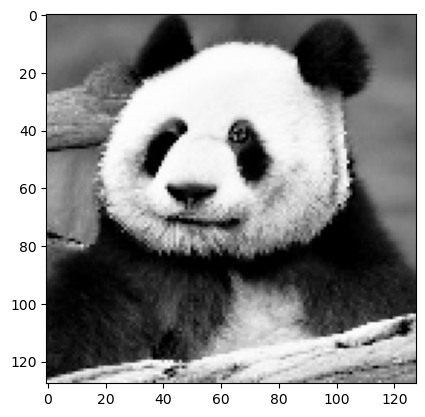

Bear index: 7


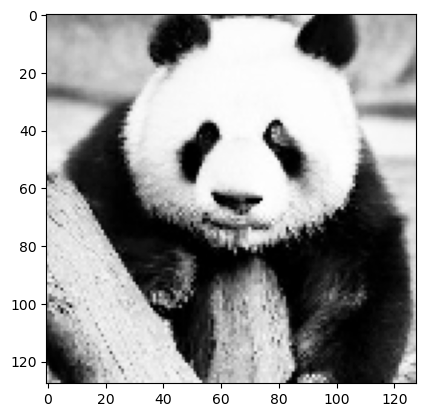

Bear index: 9


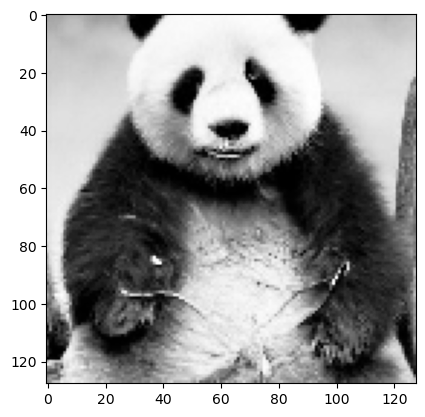

Bear index: 10


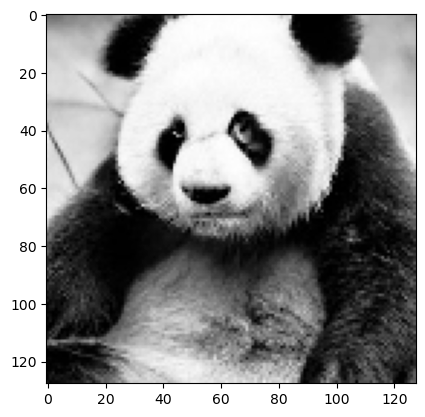

Bear index: 11


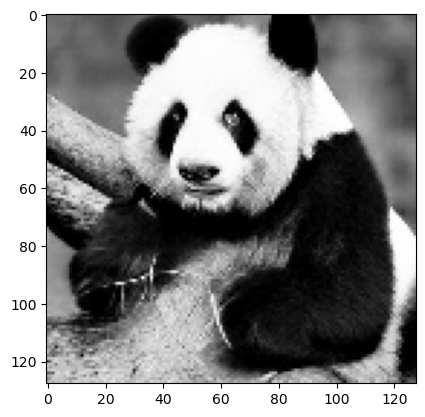

Bear index: 12


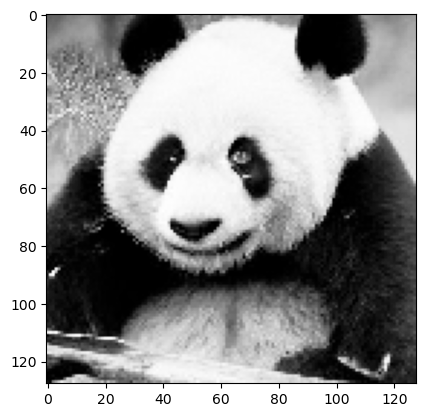

Bear index: 13


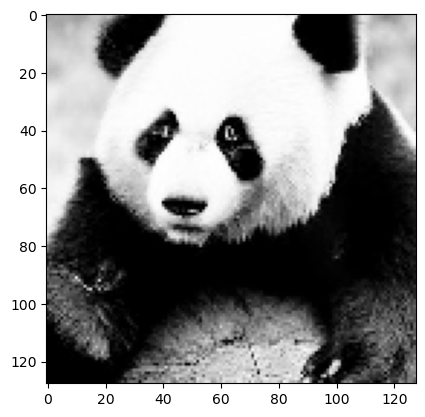

Bear index: 14


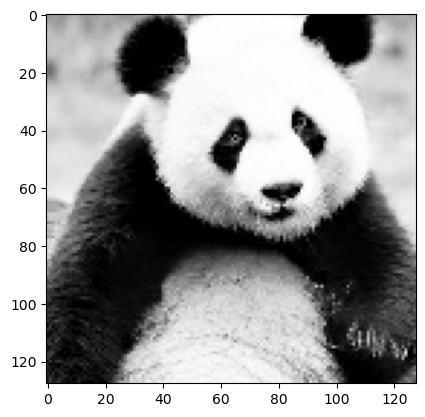

Bear index: 15


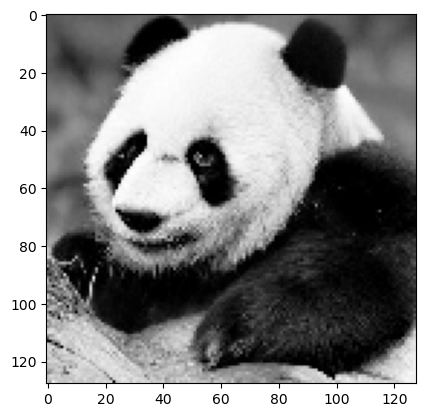

Bear index: 16


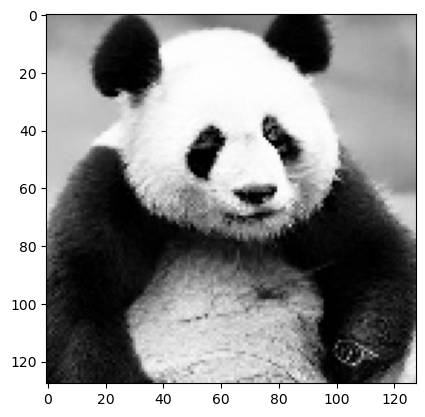

Bear index: 17


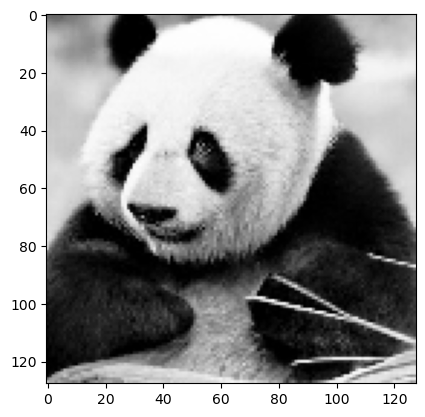

Bear index: 18


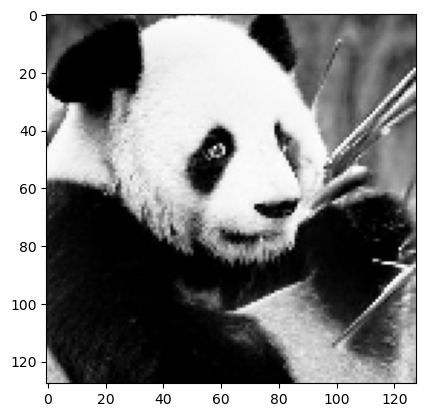

Bear index: 19


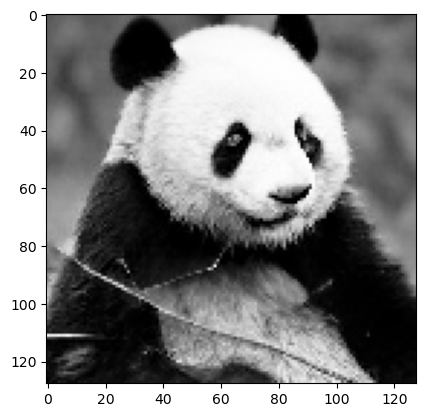

Bear index: 20


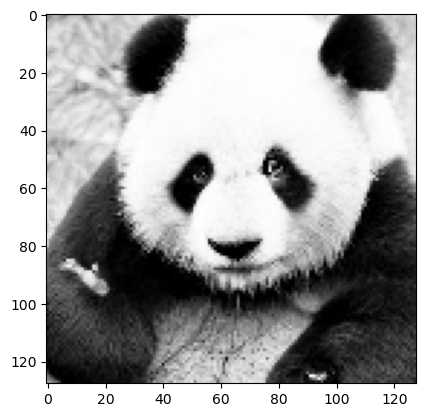

Bear index: 23


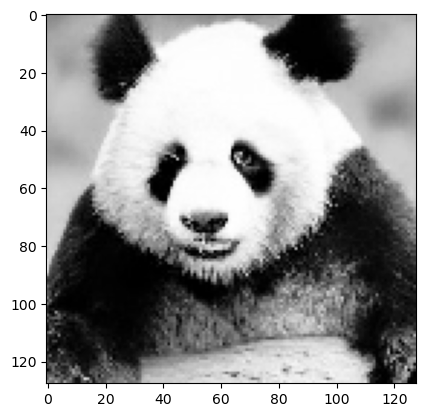

In [234]:
for i in range(25):
  if i not in hard_bears:
    print('Bear index: {}'.format(i))
    plt.imshow(test_images[i], cmap='Greys_r')
    plt.show()

It's not very clear what's the difference between the bears that are getting missclassified with the ones that are correctly classified. We can easily note that the ones that are getting misclassified seem to be in the outside of the cluster that we generate when doing a PCA with the first two Eigenbears. The misclassified bears are more likely to have logs or branches in their images but it is not an overwhelming difference.

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [236]:
test_images_flattened = np.array([image.flatten() for image in test_images])
B = (test_images_flattened - mean_image).T

# Logistic Regression
logr = LogisticRegression()
logr.fit(A.T, y_train)
logr_predictions = logr.predict(B.T)

missclassified_bears = np.where(logr_predictions != y_test)[0]

if len(missclassified_bears) == 0:
    print('No bears were misclassified by Logistic Regression')
else:
    print(f'Bear indices misclassified by Logistic Regression: {missclassified_bears}')

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(A.T, y_train)
lda_predictions = lda.predict(B.T)
lda_predictions

missclassified_bears = np.where(lda_predictions != y_test)[0]

if len(missclassified_bears) == 0:
    print('No bears were misclassified by LDA.')
else:
    print(f'Bear indices misclassified by LDA: {missclassified_bears}.')

No bears were misclassified by Logistic Regression
Bear indices misclassified by LDA: [72].


Logistic Regression performed slightly better than LDA. While Logistic Regression classified very single bear correctly, the LDA classifier made a single mistake, by classifying a brown bear as a panda.

Both the LDA and the Logistic Regression classifiers performed significantly better than the KNN, the single non-parametric classifier we tried before.

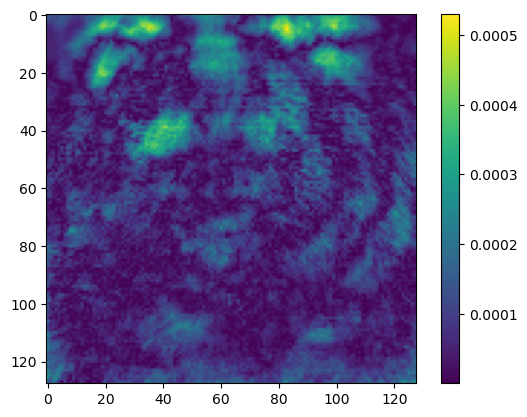

In [237]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((logr.coef_).reshape((128,128))))
plt.colorbar();

Apparently eyes and ears are the most important features for the logistic regression model to differentiate between pandas and brown bears.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

Responses

2. Test accuracy was barely affected, regardless of the model. In fact, the only difference is that linear regression made one mistake instead of zero. The reason it might not have a significant negative impact on the accuracy of the models might be that adding noise helps reduce overfitting the data so the negative influence of having noisy data might get cancelled out. Also, these models might magnify every feature in a way that makes the noise irrelevant.
3. The eigenbears had their colors inverted and the bear mask simply looked like a more pixelated version of the noise-less mask, still prioritizing ears and eyes.
4. If the scale factor was twice as big (`200` instead of `100`), then the LDA and LR wouldn't perform as well (they would make 3 or 4 mistakes) but still perform surprisingly well given that the images would be hard to identify even to humans with so much noise.